In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil

In [2]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 32
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

In [3]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                
def resample_data1(directory, target_count=300):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)

In [4]:
## Resample training data
#resample_data(train_dir)
#resample_data1(val_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 3500 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the VGG16 model without the top fully connected layers (include_top=False)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = False
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model with L2 regularization
x = base_model.output
#x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers with L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
#x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
#x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
#x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(x)
#x = Dropout(0.3)(x)
#x = Flatten()(x)

# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 299, 224, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 299, 224, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    'inceptionv3.2.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Epoch 1/1000
63/63 [==============================] - 15s 225ms/step
Epoch 1 - Validation Loss: 4.5174, Validation Accuracy: 0.3262, Validation Precision: 0.4424

Epoch 1: val_loss improved from inf to 4.51735, saving model to inceptionv3.2.h5
110/110 - 151s - loss: 5.0085 - acc: 0.3283 - val_loss: 4.5174 - val_acc: 0.3262 - lr: 1.0000e-04 - 151s/epoch - 1s/step
Epoch 2/1000
63/63 [==============================] - 14s 225ms/step
Epoch 2 - Validation Loss: 3.7172, Validation Accuracy: 0.4863, Validation Precision: 0.4731

Epoch 2: val_loss improved from 4.51735 to 3.71725, saving model to inceptionv3.2.h5
110/110 - 131s - loss: 3.9974 - acc: 0.5454 - val_loss: 3.7172 - val_acc: 0.4863 - lr: 1.0000e-04 - 131s/epoch - 1s/step
Epoch 3/1000
63/63 [==============================] - 14s 225ms/step
Epoch 3 - Validation Loss: 3.1664, Validation Accuracy: 0.5347, Validation Precision: 0.4595

Epoch 3: val_loss improved from 3.71725 to 3.16643, saving model to inceptionv3.2.h5
110/110 - 131s - l

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 132s - loss: 1.8951 - acc: 0.6554 - val_loss: 2.0064 - val_acc: 0.4469 - lr: 1.0000e-04 - 132s/epoch - 1s/step
Epoch 12/1000
63/63 [==============================] - 14s 225ms/step
Epoch 12 - Validation Loss: 1.9108, Validation Accuracy: 0.5372, Validation Precision: 0.4623

Epoch 12: val_loss improved from 2.00642 to 1.91084, saving model to inceptionv3.2.h5
110/110 - 132s - loss: 1.8488 - acc: 0.6517 - val_loss: 1.9108 - val_acc: 0.5372 - lr: 1.0000e-04 - 132s/epoch - 1s/step
Epoch 13/1000
63/63 [==============================] - 14s 225ms/step
Epoch 13 - Validation Loss: 1.8590, Validation Accuracy: 0.5162, Validation Precision: 0.4613

Epoch 13: val_loss improved from 1.91084 to 1.85898, saving model to inceptionv3.2.h5
110/110 - 132s - loss: 1.7951 - acc: 0.6463 - val_loss: 1.8590 - val_acc: 0.5162 - lr: 1.0000e-04 - 132s/epoch - 1s/step
Epoch 14/1000
63/63 [==============================] - 14s 225ms/step
Epoch 14 - Validation Loss: 1.8244, Validation Accuracy: 0.5277, 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 20 - Validation Loss: 1.6739, Validation Accuracy: 0.5382, Validation Precision: 0.4679

Epoch 20: val_loss improved from 1.71003 to 1.67389, saving model to inceptionv3.2.h5
110/110 - 132s - loss: 1.5357 - acc: 0.6614 - val_loss: 1.6739 - val_acc: 0.5382 - lr: 1.0000e-04 - 132s/epoch - 1s/step
Epoch 21/1000
63/63 [==============================] - 14s 225ms/step
Epoch 21 - Validation Loss: 1.7149, Validation Accuracy: 0.4165, Validation Precision: 0.4658

Epoch 21: val_loss did not improve from 1.67389
110/110 - 132s - loss: 1.5083 - acc: 0.6643 - val_loss: 1.7149 - val_acc: 0.4165 - lr: 1.0000e-04 - 132s/epoch - 1s/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 22 - Validation Loss: 1.6556, Validation Accuracy: 0.5092, Validation Precision: 0.4690

Epoch 22: val_loss improved from 1.67389 to 1.65555, saving model to inceptionv3.2.h5
110/110 - 131s - loss: 1.4917 - acc: 0.6606 - val_loss: 1.6556 - val_acc: 0.5092 - lr: 1.0000e-04 - 131s/epoch - 1s/step
Epoch 23/1000
63/63 [==============================] - 14s 225ms/step
Epoch 23 - Validation Loss: 1.6868, Validation Accuracy: 0.4554, Validation Precision: 0.4614

Epoch 23: val_loss did not improve from 1.65555
110/110 - 131s - loss: 1.4847 - acc: 0.6629 - val_loss: 1.6868 - val_acc: 0.4554 - lr: 1.0000e-04 - 131s/epoch - 1s/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 24 - Validation Loss: 1.6379, Validation Accuracy: 0.4863, Validation Precision: 0.4591

Epoch 24: val_loss improved from 1.65555 to 1.63792, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 132s - loss: 1.4631 - acc: 0.6560 - val_loss: 1.6379 - val_acc: 0.4863 - lr: 1.0000e-04 - 132s/epoch - 1s/step
Epoch 25/1000
63/63 [==============================] - 14s 225ms/step
Epoch 25 - Validation Loss: 1.6745, Validation Accuracy: 0.4065, Validation Precision: 0.5170

Epoch 25: val_loss did not improve from 1.63792
110/110 - 130s - loss: 1.4498 - acc: 0.6563 - val_loss: 1.6745 - val_acc: 0.4065 - lr: 1.0000e-04 - 130s/epoch - 1s/step
Epoch 26/1000
63/63 [==============================] - 14s 225ms/step
Epoch 26 - Validation Loss: 1.5634, Validation Accuracy: 0.5870, Validation Precision: 0.5046

Epoch 26: val_loss improved from 1.63792 to 1.56344, saving model to inceptionv3.2.h5
110/110 - 147s - loss: 1.4266 - acc: 0.6600 - val_loss: 1.5634 - val_acc: 0.5870 - lr: 1.0000e-04 - 147s/epoch - 1s/step
Epoch 27/1000
63/63 [==============================] - 14s 225ms/step
Epoch 27 - Validation Loss: 1.5207, Validation Accuracy: 0.5975, Validation Precision: 0.4758

Epoch 27

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 30 - Validation Loss: 1.5560, Validation Accuracy: 0.5287, Validation Precision: 0.4479

Epoch 30: val_loss did not improve from 1.51718
110/110 - 133s - loss: 1.3504 - acc: 0.6754 - val_loss: 1.5560 - val_acc: 0.5287 - lr: 1.0000e-04 - 133s/epoch - 1s/step
Epoch 31/1000
63/63 [==============================] - 15s 243ms/step
Epoch 31 - Validation Loss: 1.4740, Validation Accuracy: 0.6185, Validation Precision: 0.5116

Epoch 31: val_loss improved from 1.51718 to 1.47396, saving model to inceptionv3.2.h5
110/110 - 147s - loss: 1.3424 - acc: 0.6729 - val_loss: 1.4740 - val_acc: 0.6185 - lr: 1.0000e-04 - 147s/epoch - 1s/step
Epoch 32/1000
63/63 [==============================] - 15s 237ms/step
Epoch 32 - Validation Loss: 1.5389, Validation Accuracy: 0.5227, Validation Precision: 0.4637

Epoch 32: val_loss did not improve from 1.47396
110/110 - 159s - loss: 1.3230 - acc: 0.6789 - val_loss: 1.5389 - val_acc: 0.5227 - lr: 1.0000e-

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 233ms/step
Epoch 35 - Validation Loss: 1.4539, Validation Accuracy: 0.6020, Validation Precision: 0.4592

Epoch 35: val_loss improved from 1.47396 to 1.45388, saving model to inceptionv3.2.h5
110/110 - 168s - loss: 1.2795 - acc: 0.6809 - val_loss: 1.4539 - val_acc: 0.6020 - lr: 1.0000e-04 - 168s/epoch - 2s/step
Epoch 36/1000
63/63 [==============================] - 15s 230ms/step
Epoch 36 - Validation Loss: 1.4612, Validation Accuracy: 0.5800, Validation Precision: 0.4752

Epoch 36: val_loss did not improve from 1.45388
110/110 - 160s - loss: 1.2762 - acc: 0.6743 - val_loss: 1.4612 - val_acc: 0.5800 - lr: 1.0000e-04 - 160s/epoch - 1s/step
Epoch 37/1000
63/63 [==============================] - 15s 242ms/step
Epoch 37 - Validation Loss: 1.3972, Validation Accuracy: 0.6449, Validation Precision: 0.4674

Epoch 37: val_loss improved from 1.45388 to 1.39716, saving model to inceptionv3.2.h5
110/110 - 157s - loss: 1.2644 - acc: 0.6763 - val_loss: 1

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 236ms/step
Epoch 39 - Validation Loss: 1.3964, Validation Accuracy: 0.6244, Validation Precision: 0.5167

Epoch 39: val_loss improved from 1.39716 to 1.39641, saving model to inceptionv3.2.h5
110/110 - 156s - loss: 1.2370 - acc: 0.6843 - val_loss: 1.3964 - val_acc: 0.6244 - lr: 1.0000e-04 - 156s/epoch - 1s/step
Epoch 40/1000
63/63 [==============================] - 14s 221ms/step
Epoch 40 - Validation Loss: 1.4669, Validation Accuracy: 0.5531, Validation Precision: 0.4697

Epoch 40: val_loss did not improve from 1.39641
110/110 - 148s - loss: 1.2175 - acc: 0.6886 - val_loss: 1.4669 - val_acc: 0.5531 - lr: 1.0000e-04 - 148s/epoch - 1s/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 41 - Validation Loss: 1.3643, Validation Accuracy: 0.6474, Validation Precision: 0.4750

Epoch 41: val_loss improved from 1.39641 to 1.36427, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 126s - loss: 1.2175 - acc: 0.6849 - val_loss: 1.3643 - val_acc: 0.6474 - lr: 1.0000e-04 - 126s/epoch - 1s/step
Epoch 42/1000
63/63 [==============================] - 14s 217ms/step
Epoch 42 - Validation Loss: 1.4030, Validation Accuracy: 0.5990, Validation Precision: 0.4540

Epoch 42: val_loss did not improve from 1.36427
110/110 - 125s - loss: 1.2061 - acc: 0.6863 - val_loss: 1.4030 - val_acc: 0.5990 - lr: 1.0000e-04 - 125s/epoch - 1s/step
Epoch 43/1000
63/63 [==============================] - 14s 222ms/step
Epoch 43 - Validation Loss: 1.3530, Validation Accuracy: 0.6434, Validation Precision: 0.4555

Epoch 43: val_loss improved from 1.36427 to 1.35299, saving model to inceptionv3.2.h5
110/110 - 125s - loss: 1.1972 - acc: 0.6811 - val_loss: 1.3530 - val_acc: 0.6434 - lr: 1.0000e-04 - 125s/epoch - 1s/step
Epoch 44/1000
63/63 [==============================] - 14s 217ms/step
Epoch 44 - Validation Loss: 1.2929, Validation Accuracy: 0.7077, Validation Precision: 0.5789

Epoch 44

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 221ms/step
Epoch 46 - Validation Loss: 1.5096, Validation Accuracy: 0.4968, Validation Precision: 0.4639

Epoch 46: val_loss did not improve from 1.29291
110/110 - 129s - loss: 1.1714 - acc: 0.6860 - val_loss: 1.5096 - val_acc: 0.4968 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 47/1000
63/63 [==============================] - 14s 217ms/step
Epoch 47 - Validation Loss: 1.3401, Validation Accuracy: 0.6414, Validation Precision: 0.4584

Epoch 47: val_loss did not improve from 1.29291
110/110 - 128s - loss: 1.1649 - acc: 0.6829 - val_loss: 1.3401 - val_acc: 0.6414 - lr: 1.0000e-04 - 128s/epoch - 1s/step
Epoch 48/1000
63/63 [==============================] - 14s 223ms/step
Epoch 48 - Validation Loss: 1.3565, Validation Accuracy: 0.6140, Validation Precision: 0.4595

Epoch 48: val_loss did not improve from 1.29291
110/110 - 132s - loss: 1.1441 - acc: 0.6909 - val_loss: 1.3565 - val_acc: 0.6140 - lr: 1.0000e-04 - 132s/epoch - 1s/step
Epoch 49/100

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 221ms/step
Epoch 49 - Validation Loss: 1.4329, Validation Accuracy: 0.5392, Validation Precision: 0.4444

Epoch 49: val_loss did not improve from 1.29291
110/110 - 154s - loss: 1.1373 - acc: 0.6874 - val_loss: 1.4329 - val_acc: 0.5392 - lr: 1.0000e-04 - 154s/epoch - 1s/step
Epoch 50/1000
63/63 [==============================] - 14s 222ms/step
Epoch 50 - Validation Loss: 1.3752, Validation Accuracy: 0.5825, Validation Precision: 0.4599

Epoch 50: val_loss did not improve from 1.29291
110/110 - 147s - loss: 1.1140 - acc: 0.6966 - val_loss: 1.3752 - val_acc: 0.5825 - lr: 5.0000e-05 - 147s/epoch - 1s/step
Epoch 51/1000
63/63 [==============================] - 14s 223ms/step
Epoch 51 - Validation Loss: 1.4744, Validation Accuracy: 0.4928, Validation Precision: 0.4667

Epoch 51: val_loss did not improve from 1.29291
110/110 - 157s - loss: 1.1071 - acc: 0.6971 - val_loss: 1.4744 - val_acc: 0.4928 - lr: 5.0000e-05 - 157s/epoch - 1s/step
Epoch 52/100

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 224ms/step
Epoch 56 - Validation Loss: 1.3522, Validation Accuracy: 0.5835, Validation Precision: 0.4768

Epoch 56: val_loss did not improve from 1.28929
110/110 - 156s - loss: 1.0724 - acc: 0.7026 - val_loss: 1.3522 - val_acc: 0.5835 - lr: 5.0000e-05 - 156s/epoch - 1s/step
Epoch 57/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 222ms/step
Epoch 57 - Validation Loss: 1.3618, Validation Accuracy: 0.5736, Validation Precision: 0.4638

Epoch 57: val_loss did not improve from 1.28929
110/110 - 145s - loss: 1.0685 - acc: 0.7020 - val_loss: 1.3618 - val_acc: 0.5736 - lr: 5.0000e-05 - 145s/epoch - 1s/step
Epoch 58/1000
63/63 [==============================] - 14s 225ms/step
Epoch 58 - Validation Loss: 1.2655, Validation Accuracy: 0.6589, Validation Precision: 0.4761

Epoch 58: val_loss improved from 1.28929 to 1.26545, saving model to inceptionv3.2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 157s - loss: 1.0626 - acc: 0.7031 - val_loss: 1.2655 - val_acc: 0.6589 - lr: 5.0000e-05 - 157s/epoch - 1s/step
Epoch 59/1000
63/63 [==============================] - 14s 223ms/step
Epoch 59 - Validation Loss: 1.2419, Validation Accuracy: 0.6763, Validation Precision: 0.4615

Epoch 59: val_loss improved from 1.26545 to 1.24190, saving model to inceptionv3.2.h5
110/110 - 150s - loss: 1.0563 - acc: 0.7046 - val_loss: 1.2419 - val_acc: 0.6763 - lr: 5.0000e-05 - 150s/epoch - 1s/step
Epoch 60/1000
63/63 [==============================] - 14s 223ms/step
Epoch 60 - Validation Loss: 1.2743, Validation Accuracy: 0.6414, Validation Precision: 0.4618

Epoch 60: val_loss did not improve from 1.24190
110/110 - 153s - loss: 1.0541 - acc: 0.7040 - val_loss: 1.2743 - val_acc: 0.6414 - lr: 5.0000e-05 - 153s/epoch - 1s/step
Epoch 61/1000
63/63 [==============================] - 14s 222ms/step
Epoch 61 - Validation Loss: 1.2695, Validation Accuracy: 0.6399, Validation Precision: 0.4657

Epoch 61

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 64 - Validation Loss: 1.3188, Validation Accuracy: 0.6040, Validation Precision: 0.4670

Epoch 64: val_loss did not improve from 1.24190
110/110 - 144s - loss: 1.0331 - acc: 0.7051 - val_loss: 1.3188 - val_acc: 0.6040 - lr: 5.0000e-05 - 144s/epoch - 1s/step
Epoch 65/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 230ms/step
Epoch 65 - Validation Loss: 1.2578, Validation Accuracy: 0.6469, Validation Precision: 0.4579

Epoch 65: val_loss did not improve from 1.24190
110/110 - 157s - loss: 1.0280 - acc: 0.7057 - val_loss: 1.2578 - val_acc: 0.6469 - lr: 2.5000e-05 - 157s/epoch - 1s/step
Epoch 66/1000
63/63 [==============================] - 16s 246ms/step
Epoch 66 - Validation Loss: 1.2265, Validation Accuracy: 0.6648, Validation Precision: 0.4669

Epoch 66: val_loss improved from 1.24190 to 1.22648, saving model to inceptionv3.2.h5
110/110 - 158s - loss: 1.0226 - acc: 0.7086 - val_loss: 1.2265 - val_acc: 0.6648 - lr: 2.5000e-05 - 158s/epoch - 1s/step
Epoch 67/1000
63/63 [==============================] - 16s 249ms/step
Epoch 67 - Validation Loss: 1.2590, Validation Accuracy: 0.6419, Validation Precision: 0.4525

Epoch 67: val_loss did not improve from 1.22648
110/110 - 181s - loss: 1.0204 - acc: 0.7091 - val_loss: 1.2590 - val_acc: 0.6419 - lr: 2.5000e-

In [8]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

63/63 [==============================] - 15s 230ms/step
Final Precision: 0.4559
Final Recall: 0.3771
Final F1 Score: 0.4008


48/48 [==============================] - 18s 382ms/step - loss: 1.2867 - acc: 0.6099
Test accuracy: 0.6099010109901428


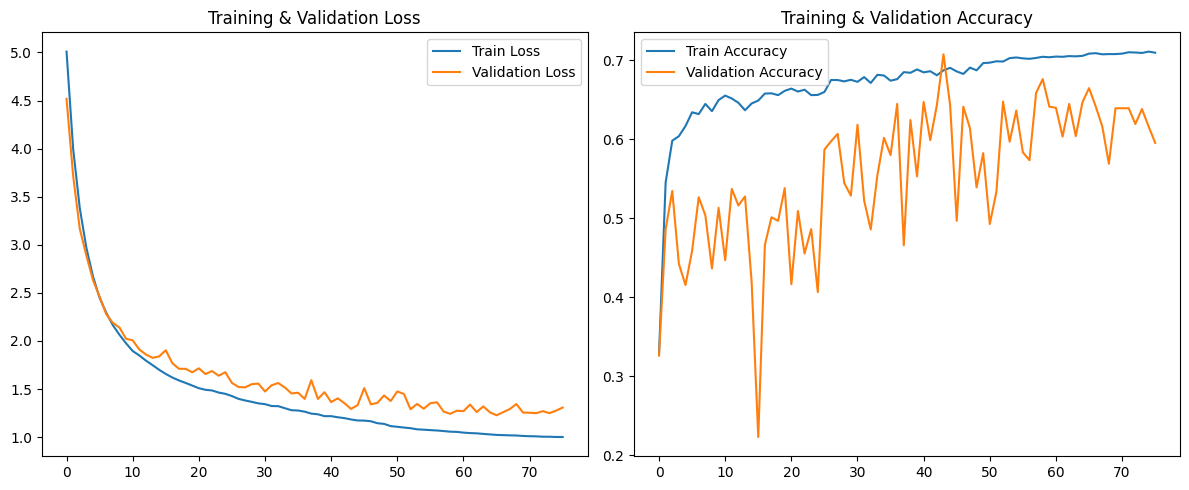

In [9]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

110/110 [==============================] - 99s 900ms/step


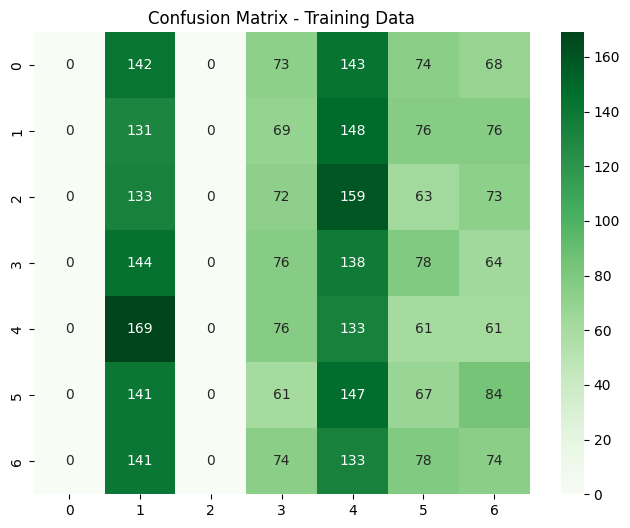

63/63 [==============================] - 14s 219ms/step


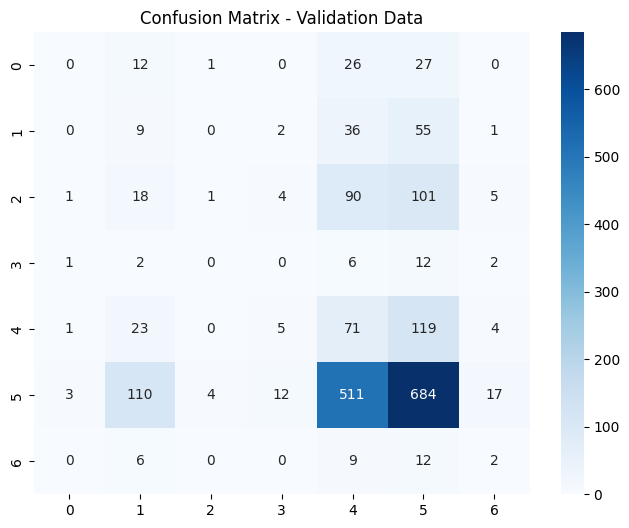

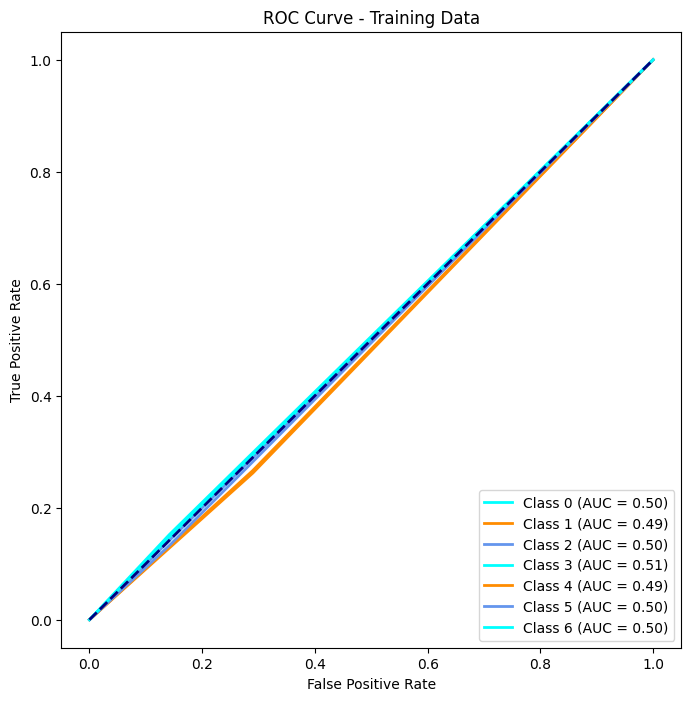

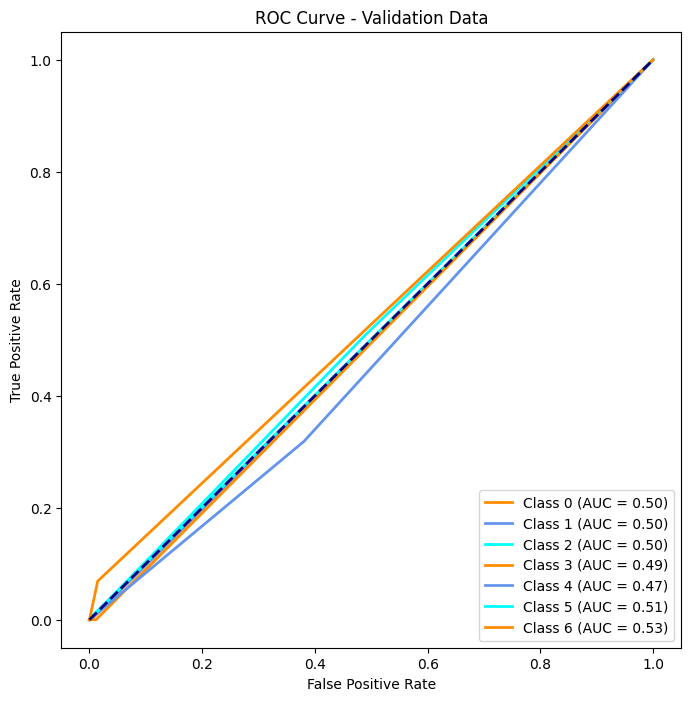

In [10]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()
